In [70]:
import faker
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import os

In [72]:
# global constants
NATIONALITIES = ("USA", "UK", "Canada", "Australia", "India", "Germany", "France", "Italy", "Japan", "China")
GENDERS = ("Male", "Female", "Other")
ROOM_TYPES = ("Standard", "Deluxe", "Superior")
SPECIALISATIONS = ("Ski", "Showboard")
EQUIPMENT_CATEGORIES = ("Ski", "Snowboard", "Helmet", "Boots")
EQUIPMENT_SIZE = ("S", "M", "L", "XL")
PAYMENT_METHODS = ("Credit Card", "Debit Card", "Paypal")
LESSON_LEVELS = ("Beginner", "Intermediate", "Advanced")
ROOM_PRICES = {"Standard": 60, "Deluxe": 100, "Superior": 120}
EQUIPMENT_PRICES = {"Ski": 10, "Snowboard": 10, "Helmet": 20, "Boots": 20}
LESSON_PRICES = {"Beginner": 30, "Intermediate": 40, "Advanced": 50}

# faker instance
fake = faker.Faker()


def normal_cropped(mean, std, min_value, max_value):
    value = np.random.normal(mean, std)
    while value < min_value or value > max_value:
        value = np.random.normal(mean, std)
    return value


class User:
    def __init__(self):
        self.id = fake.uuid4()
        self.fname = fake.first_name()
        self.lname = fake.last_name()
        self.email = fake.email()
        self.phone = fake.phone_number()
        self.address = fake.address()
        self.age = int(normal_cropped(38, 7, 16, 60))
        self.nationality = np.random.choice(NATIONALITIES)
        self.gender = np.random.choice(GENDERS)
        
    def make_booking(self, date, facility):
        booking = Booking(user_id = self.id, check_in_date = date, facility=facility, rich_user=True if np.random.rand() <= 0.2 else False)
        facility.bookings.append(booking)
        transaction = Transaction(user_id = self.id, facility=facility, booking = booking, transaction_date = date)
        facility.transactions.append(transaction)
        
    def rent_equipment(self, date, facility):
        rental = Rental(user_id = self.id, rental_date = date, facility=facility)
        facility.rentals.append(rental)
        transaction = Transaction(user_id = self.id, facility=facility, rental = rental, transaction_date = date)
        facility.transactions.append(transaction)
        
    def take_lesson(self, date, facility):
        lesson = Lesson(user_id = self.id, lesson_date = date, facility=facility)
        facility.lessons.append(lesson)
        transaction = Transaction(user_id = self.id, facility=facility, lesson = lesson, transaction_date = date)
        facility.transactions.append(transaction)
        
    def act(self, date, facility):
        # each user has a 70% chance of renting equipment
        # and a 10% chance of taking a lesson
        if np.random.rand() < 0.7:
            self.rent_equipment(date, facility)
        if np.random.rand() < 0.1:
            self.take_lesson(date, facility)
    
   
class Room:
    def __init__(self, room_type="Standard"):
        self.id = fake.uuid4()
        self.type = room_type
        
        # price per night based on the room capacity
        self.price_per_night = ROOM_PRICES[self.type]
        
        self.description = fake.paragraph()
        

class Instructor:
    def __init__(self):
        self.id = fake.uuid4()
        self.fname = fake.first_name()
        self.lname = fake.last_name()
        self.phone = fake.phone_number()
        self.email = fake.email()
        self.specialisation = np.random.choice(SPECIALISATIONS)

    
class Equipment:
    def __init__(self):
        self.id = fake.uuid4()
        self.category = np.random.choice(EQUIPMENT_CATEGORIES)
        self.brand = fake.company()
        self.model = fake.word()
        self.size = np.random.choice(EQUIPMENT_SIZE)
        # price per hour based on the equipment category
        self.price_per_hour = EQUIPMENT_PRICES[self.category]


class Facility:
    INSTRUCTOR_COUNT = 100
    ROOM_COUNT = 300
    EQUIPMENT_COUNT = 200
    
    def __init__(self):
        self.instructors = [Instructor() for _ in range(Facility.INSTRUCTOR_COUNT)]
        
        # create more standard rooms and less expensive rooms
        # standard room number is 60% of total rooms
        # deluxe room number is 30% of total rooms
        # superior room number is 10% of total rooms
        standard_rooms = int(Facility.ROOM_COUNT * 0.6)
        deluxe_rooms = int(Facility.ROOM_COUNT * 0.3)
        superior_rooms = Facility.ROOM_COUNT - standard_rooms - deluxe_rooms
        self.rooms = [Room(room_type="Standard") for _ in range(standard_rooms)]
        self.rooms += [Room(room_type="Deluxe") for _ in range(deluxe_rooms)]
        self.rooms += [Room(room_type="Superior") for _ in range(superior_rooms)]
        
        self.equipments = [Equipment() for _ in range(Facility.EQUIPMENT_COUNT)]
        
        self.bookings = []
        self.rentals = []
        self.lessons = []
        self.transactions = []
        
    def instructors_available(self, date):
        # get all instructor ids for each lesson at the given date
        instructor_ids = [lesson.instructor_id for lesson in self.lessons if lesson.lesson_date == date]
        
        # return all instructors that are not booked on the given date
        return [instructor for instructor in self.instructors if instructor.id not in instructor_ids]
        
    def equipment_available(self, date):
        # get all equipment ids for each rental at the given date
        equipment_ids = [rental.equipment_id for rental in self.rentals if rental.rental_date == date]
        
        # return all equipment that is not rented on the given date
        return [equipment for equipment in self.equipments if equipment.id not in equipment_ids]
    
    def rooms_available(self, date):
        # get all room ids for each booking at the given date
        room_ids = [booking.room_id for booking in self.bookings if booking.check_in_date <= date <= booking.check_out_date]
        
        # return all rooms that are not booked on the given date
        return sorted([room for room in self.rooms if room.id not in room_ids], key=lambda x: x.price_per_night)
    
    def get_booking_price(self, booking):
        # get the booking price for the given booking
        return booking.booking_price
    
    def get_rental_price(self, rental):
        # get the rental price for the given rental
        return rental.rental_price
    
    def get_lesson_price(self, lesson):
        # get the lesson price for the given lesson
        return lesson.lesson_price

    
class Booking:
    def __init__(self, user_id, check_in_date, facility, rich_user=False):
        self.id = fake.uuid4()
        self.user_id = user_id
        self.check_in_date = check_in_date
        
        # check-out date is several days after check-in date
        self.check_out_date = check_in_date + timedelta(days=int(normal_cropped(3, .22, 1, 7)))
        
        # assign random room from the rooms available on the check-in date
        available_rooms = facility.rooms_available(check_in_date)
        if rich_user:
            room = available_rooms[-1]
        else:
            room = available_rooms[0]
            
        self.room_id = room.id
        
        # booking price is calculated based on the room price and the duration of stay
        self.booking_price = room.price_per_night * (self.check_out_date - self.check_in_date).days
        

class Transaction:
    def __init__(self, user_id, facility, rental=None, lesson=None, booking=None, transaction_date=None):
        self.id = fake.uuid4()
        self.user_id = user_id
        self.rental_id = rental.id if rental is not None else None
        self.lesson_id = lesson.id if lesson is not None else None
        self.booking_id = booking.id if booking is not None else None
        
        # if it's a booking transaction, then the transaction date is
        # several days earlier than the date provided
        self.transaction_date = transaction_date if booking is None else transaction_date - timedelta(days=np.random.randint(3, 30))
        
        #TODO transaction amount
        if booking is not None:
            self.transaction_amount = facility.get_booking_price(booking)
        if rental is not None:
            self.transaction_amount = facility.get_rental_price(rental)
        if lesson is not None:
            self.transaction_amount = facility.get_lesson_price(lesson)
        
        self.payment_method = np.random.choice(PAYMENT_METHODS)
    
    
class Rental:
    def __init__(self, user_id, rental_date, facility):
        self.id = fake.uuid4()
        self.user_id = user_id
        self.rental_date = rental_date
        
        # assign random equipment from the available equipment
        available_equipment = facility.equipment_available(rental_date)
        equipment = np.random.choice(available_equipment)
        self.equipment_id = equipment.id
        
        # rental duration is a random number (normally distributed)
        self.duration_hours = int(normal_cropped(4, 1, 1, 8))
        
        # rental price is calculated based on the equipment price and the duration of rental
        self.rental_price = equipment.price_per_hour * self.duration_hours
        
        
class Lesson:
    def __init__(self, user_id, lesson_date, facility):
        self.id = fake.uuid4()
        self.user_id = user_id
        self.lesson_date = lesson_date
        
        available_instructors = facility.instructors_available(lesson_date)
        self.instructor_id = np.random.choice(available_instructors).id
        
        self.lesson_level = np.random.choice(LESSON_LEVELS)
        self.duration_hours = np.random.randint(1, 3)
        
        self.lesson_price = LESSON_PRICES[self.lesson_level]*self.duration_hours
    

class Population:
    def __init__(self):
        self.users = []
        
    def make_bookings(self, date, increment, facility):
        # base amount of users (summer season)
        n_users = np.random.normal(25, 5)
        
        # if it's between summer and winter season, slightly increase the amount of users
        n_users += np.random.normal(5, 2) if date.month in [10, 5] else 0
        
        # if it's close to winter season, increase the amount of users
        n_users += np.random.normal(10, 4) if date.month in [11, 4] else 0
        
        # if it's winter season, significantly increase the amount of users
        n_users += np.random.normal(25, 5) if date.month in [12, 1, 2, 3] else 0
        
        # if it's a weekend day, incerase the amount of users even more
        n_users += np.random.randint(5, 10) if date.weekday() in [5, 6] else 0
        
        # simulate growth of users over time
        n_users += increment
        
        # simulate the amount of users making bookings on the given date
        for _ in range(max(int(n_users), 0)):
            user = User()
            self.users.append(user)
            user.make_booking(date, facility)
            
    def _get_users_on_site(self, date, facility):
        # get all user ids for each booking at the given date
        user_ids = [booking.user_id for booking in facility.bookings if booking.check_in_date <= date <= booking.check_out_date]
        
        # return all users that are on-site on the given date
        return [user for user in self.users if user.id in user_ids]
    
    def act_in_facility(self, date, facility):
        # simulate the users' activities in the facility
        # select only users who are on-site on the given date
        users = self._get_users_on_site(date, facility)
        
        # iterate over each user and simulate their behaviour
        for user in users:
            user.act(date, facility)
        
        
class Simulation:    
    def __init__(self):
        self.facility = Facility()
        self.population = Population()
        
    def run(self, start_date=None, end_date=None):
        if start_date is None or end_date is None:
            start_date = datetime.now()
            end_date = start_date + timedelta(days=365)
        
        # iterate over dates within the simulation period 
        current_date = start_date
        user_number_increment = 0
        while current_date <= end_date:
            self.population.make_bookings(current_date, user_number_increment, self.facility)
            current_date += timedelta(days=1)
            
        
        # iterate over booking dates
        current_date = start_date
        while current_date <= max([booking.check_out_date for booking in self.facility.bookings]):
            self.population.act_in_facility(current_date, self.facility)
            current_date += timedelta(days=1)
            
            
    def dataframes(self):
        result = {
            "users": pd.DataFrame([vars(user) for user in self.population.users]),
            "rooms": pd.DataFrame([vars(room) for room in self.facility.rooms]),
            "bookings": pd.DataFrame([vars(booking) for booking in self.facility.bookings]),
            "transactions": pd.DataFrame([vars(transaction) for transaction in self.facility.transactions]),
            "instructors": pd.DataFrame([vars(instructor) for instructor in self.facility.instructors]),
            "equipment": pd.DataFrame([vars(equipment) for equipment in self.facility.equipments]),
            "rentals": pd.DataFrame([vars(rental) for rental in self.facility.rentals]),
            "lessons": pd.DataFrame([vars(lesson) for lesson in self.facility.lessons])
        }
        return result
    
    def save_dataframes(self, dir="csv_data"):
        if not os.path.exists(dir):
            os.makedirs(dir)
        dataframes = self.dataframes()
        for name, df in dataframes.items():
            df.to_csv(f"{dir}/{name}.csv", index=False)
        

if __name__ == "__main__":
    START_DATE = datetime(2023, 7, 1)
    END_DATE = datetime(2024, 11, 1)
    
    sim = Simulation()
    
    sim.run(start_date=START_DATE, end_date=END_DATE)

In [73]:
data = sim.dataframes()
data = sim.save_dataframes()

users = data["users"]
rooms = data["rooms"]
bookings = data["bookings"]
transactions = data["transactions"]
instructors = data["instructors"]
equipment = data["equipment"]
rentals = data["rentals"]
lessons = data["lessons"]


TypeError: 'NoneType' object is not subscriptable

In [64]:
print(f"lessons: {len(lessons)}")
print(f"bookings: {len(bookings)}")
print(f"rentals: {len(rentals)}")
print(f"transactions: {len(transactions)}")
print(f"users: {len(users)}")
print(f"rooms: {len(rooms)}")
print(f"equipment: {len(equipment)}")
print(f"instructors: {len(instructors)}")  
print(len(lessons) + len(bookings) + len(rentals) == len(transactions))


lessons: 5975
bookings: 16988
rentals: 41813
transactions: 64776
users: 16988
rooms: 300
equipment: 200
instructors: 100
True


<Axes: xlabel='rental_date'>

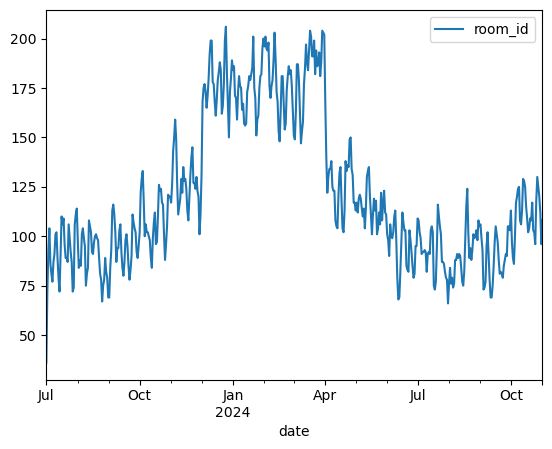

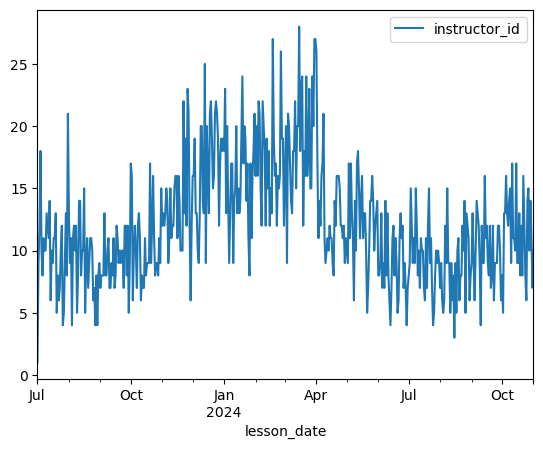

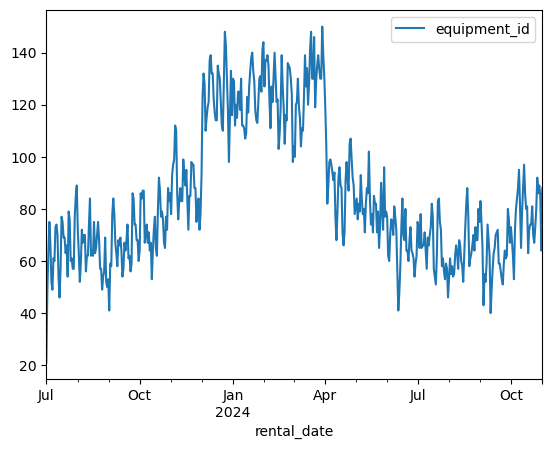

In [74]:
# check for inefficiencies in the amount of instructors, rooms and equipment
# generate a time-series table with the daily amount of each of the three

# rooms
rooms_timeseries = bookings.copy()
rooms_timeseries["date"] = rooms_timeseries.apply(lambda row: list(pd.date_range(row["check_in_date"], row["check_out_date"])), axis=1)
rooms_timeseries = rooms_timeseries[["date", "room_id"]]
rooms_timeseries = rooms_timeseries.explode("date", ignore_index=True)
rooms_timeseries.groupby("date").count()[:-3].plot()

# instructors
instructors_timeseries = lessons.copy()
instructors_timeseries = instructors_timeseries[["lesson_date", "instructor_id"]]
instructors_timeseries.groupby("lesson_date").count()[:-3].plot()

# equipment
equipment_timeseries = rentals.copy()
equipment_timeseries = equipment_timeseries[["rental_date", "equipment_id"]]
equipment_timeseries.groupby("rental_date").count()[:-3].plot()

In [75]:
# check for the most popular room type

result = pd.merge(bookings, rooms, left_on="room_id", right_on="id", how="left")[["id_x", "type"]]
result.groupby("type").count()

,id_x
type,
Deluxe,318
Standard,13534
Superior,3136


In [76]:
# room type distribution
rooms["type"].value_counts()

type
Standard    180
Deluxe       90
Superior     30
Name: count, dtype: int64